In [1]:
import matplotlib.pyplot as plt
import re
import matplotlib.ticker as ticker
from paddleocr.paddleocr import PaddleOCR
import cv2
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Polygon
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np

from transformers import AutoModelForTokenClassification
from transformers import AutoProcessor
import torch

from PIL import Image, ImageDraw, ImageFont
import sys

sys.path.append(r'/home/enestydarealmc/Git/Thesis/tools/')

from bbox_utils import normalize_coord, unnormalize_coord, axis_align_bound_box

%matplotlib inline

In [2]:
ocr_model = PaddleOCR(use_angle_cls=False, lang='en',
                  structure_version='PP-Structure',
                  det_model_dir = '/home/enestydarealmc/Git/PaddleOCRTraining/PaddleOCR/output/det_db_inference/inference_ggdrive',
                  rec_model_dir = '/home/enestydarealmc/Git/PaddleOCRTraining/PaddleOCR/output/en_PP-OCRv3_rec_inference',
                  use_gpu=False,
                  det_pse_box_thresh = 0.75, 
                  det_limit_side_len = 4000,
                  det_box_type='quad',
                  use_dilation=True, use_tensorrt=True, image_orientation=True, 
                  det_db_score_mode='slow', use_pse=True,
                  det_db_box_thresh=0.3,
                  det_db_thresh=0.3, det_db_unclip_ratio=1.2,
                  drop_score=0.5, text_thresh=0.5
                  )

[2023/06/01 19:29:02] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/enestydarealmc/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.3, det_db_score_mode='slow', det_db_thresh=0.3, det_db_unclip_ratio=1.2, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=4000, det_limit_type='max', det_model_dir='/home/enestydarealmc/Git/PaddleOCRTraining/PaddleOCR/output/det_db_inference/inference_ggdrive', det_pse_box_thresh=0.75, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet

In [3]:
inference_model = AutoModelForTokenClassification.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-wildreceipt").to("cuda")
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)


2023-06-01 19:29:07.786655: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 19:29:07.999037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 19:29:08.685728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def iob_to_label(label):
    #label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {
    "Date_key": 'red',
    "Date_value": 'green',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'green',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'green',
    "Store_name_key": 'red',
    "Store_name_value": 'green',
    "Subtotal_key": 'red',
    "Subtotal_value": 'green',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

In [5]:
def split_rectangle(points, text, punctuation):
    # split text and get length
    left_text, right_text = text.split(punctuation, maxsplit=1)
    total_length = len(text.replace(' ', '').replace(punctuation, ''))
    left_length = len(left_text.replace(' ', ''))
    
    # calculate split ratio
    split_ratio = left_length / total_length
    
    # calculate split point
    p0, p1, p2, p3 = np.array(points)
    split_point = p0 + (p1 - p0) * split_ratio
    split_point_2 = p3 + (p2 - p3) * split_ratio
    
    left_points = np.array([p0.tolist(), split_point.tolist(), split_point_2.tolist(), p3.tolist()]).tolist()
    
    right_points = np.array([split_point.tolist(), p1.tolist(), p2.tolist(), split_point_2.tolist()]).tolist()
    
    # return split rectangles and texts
    return [left_points, left_text.strip()], [right_points, right_text.strip()]

In [10]:
def OCR(ocr_model: PaddleOCR, img: np.ndarray):
    ocr_results = ocr_model.ocr(img)
    height, width = img.shape[:2]
    
    boxes = [line[0] for line in ocr_results[0]]
    txts = [str(line[1][0]) for line in ocr_results[0]]
    
    splitted_boxes = []
    splited_txts = []
    punctuation = ":"
    for box, text in zip(boxes, txts):
        if punctuation in text:
            left_text, right_text = text.split(punctuation, maxsplit=1)
            if left_text.strip() != '' and right_text.strip() != '':
                splited_box = split_rectangle(box, text, punctuation)
                
                splitted_boxes.append(splited_box[0][0])
                splited_txts.append(splited_box[0][1])
                splitted_boxes.append(splited_box[1][0])
                splited_txts.append(splited_box[1][1])
            else:
                splitted_boxes.append(box)
                splited_txts.append(text)
        else:
            splitted_boxes.append(box)
            splited_txts.append(text)
    
    # convert to axis-aligned boxes and normalize boxes 
    
    aligned_boxes = [axis_align_bound_box(box) for box in splitted_boxes]

    
    normalized_boxes = [normalize_coord(box, width, height) for box in aligned_boxes]
    
    
    return normalized_boxes, splited_txts
    
def inference(img_path, inference_model, processor, ocr_model):
    img = cv2.imread(img_path)
    height, width = img.shape[:2]
    
    boxes, words = OCR(ocr_model, img)
    filler_tags = [0 for _ in range(len(boxes))]
    
    encoding = processor(img, [words], boxes=[boxes], word_labels=[filler_tags], return_tensors="pt", truncation=True).to("cuda")
    
    
    with torch.no_grad():
        outputs = inference_model(**encoding)
        
    logits = outputs.logits
    predictions = logits.argmax(-1).squeeze().tolist()
    labels = encoding.labels.squeeze().tolist()
    
    token_boxes = encoding.bbox.squeeze().tolist()
    
    label_preds = [inference_model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
    box_preds = [unnormalize_coord(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]
    
    fig, ax = plt.subplots(1,1, figsize=(30,30))
    
    for prediction, box in zip(label_preds, box_preds):
        box = np.array([box[:2], [box[0], box[3]], box[2:], [box[2], box[1]]])
        predicted_label = iob_to_label(prediction)
        # if predicted_label == 'Others':
        #     continue
        ax.text(box[0][0]-10, box[0][1]-10, predicted_label, fontsize=5)
    
        paddle_polygon = Polygon(box, closed=True, fill=None, edgecolor='red')
        ax.add_patch(paddle_polygon)
    
    
    ax.imshow(img)
    ax.set_title(img_path)
    plt.show()
            
    

[2023/06/01 19:30:28] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/06/01 19:30:34] ppocr DEBUG: dt_boxes num : 39, elapse : 5.886785984039307
[2023/06/01 19:30:35] ppocr DEBUG: rec_res num  : 39, elapse : 1.3906035423278809


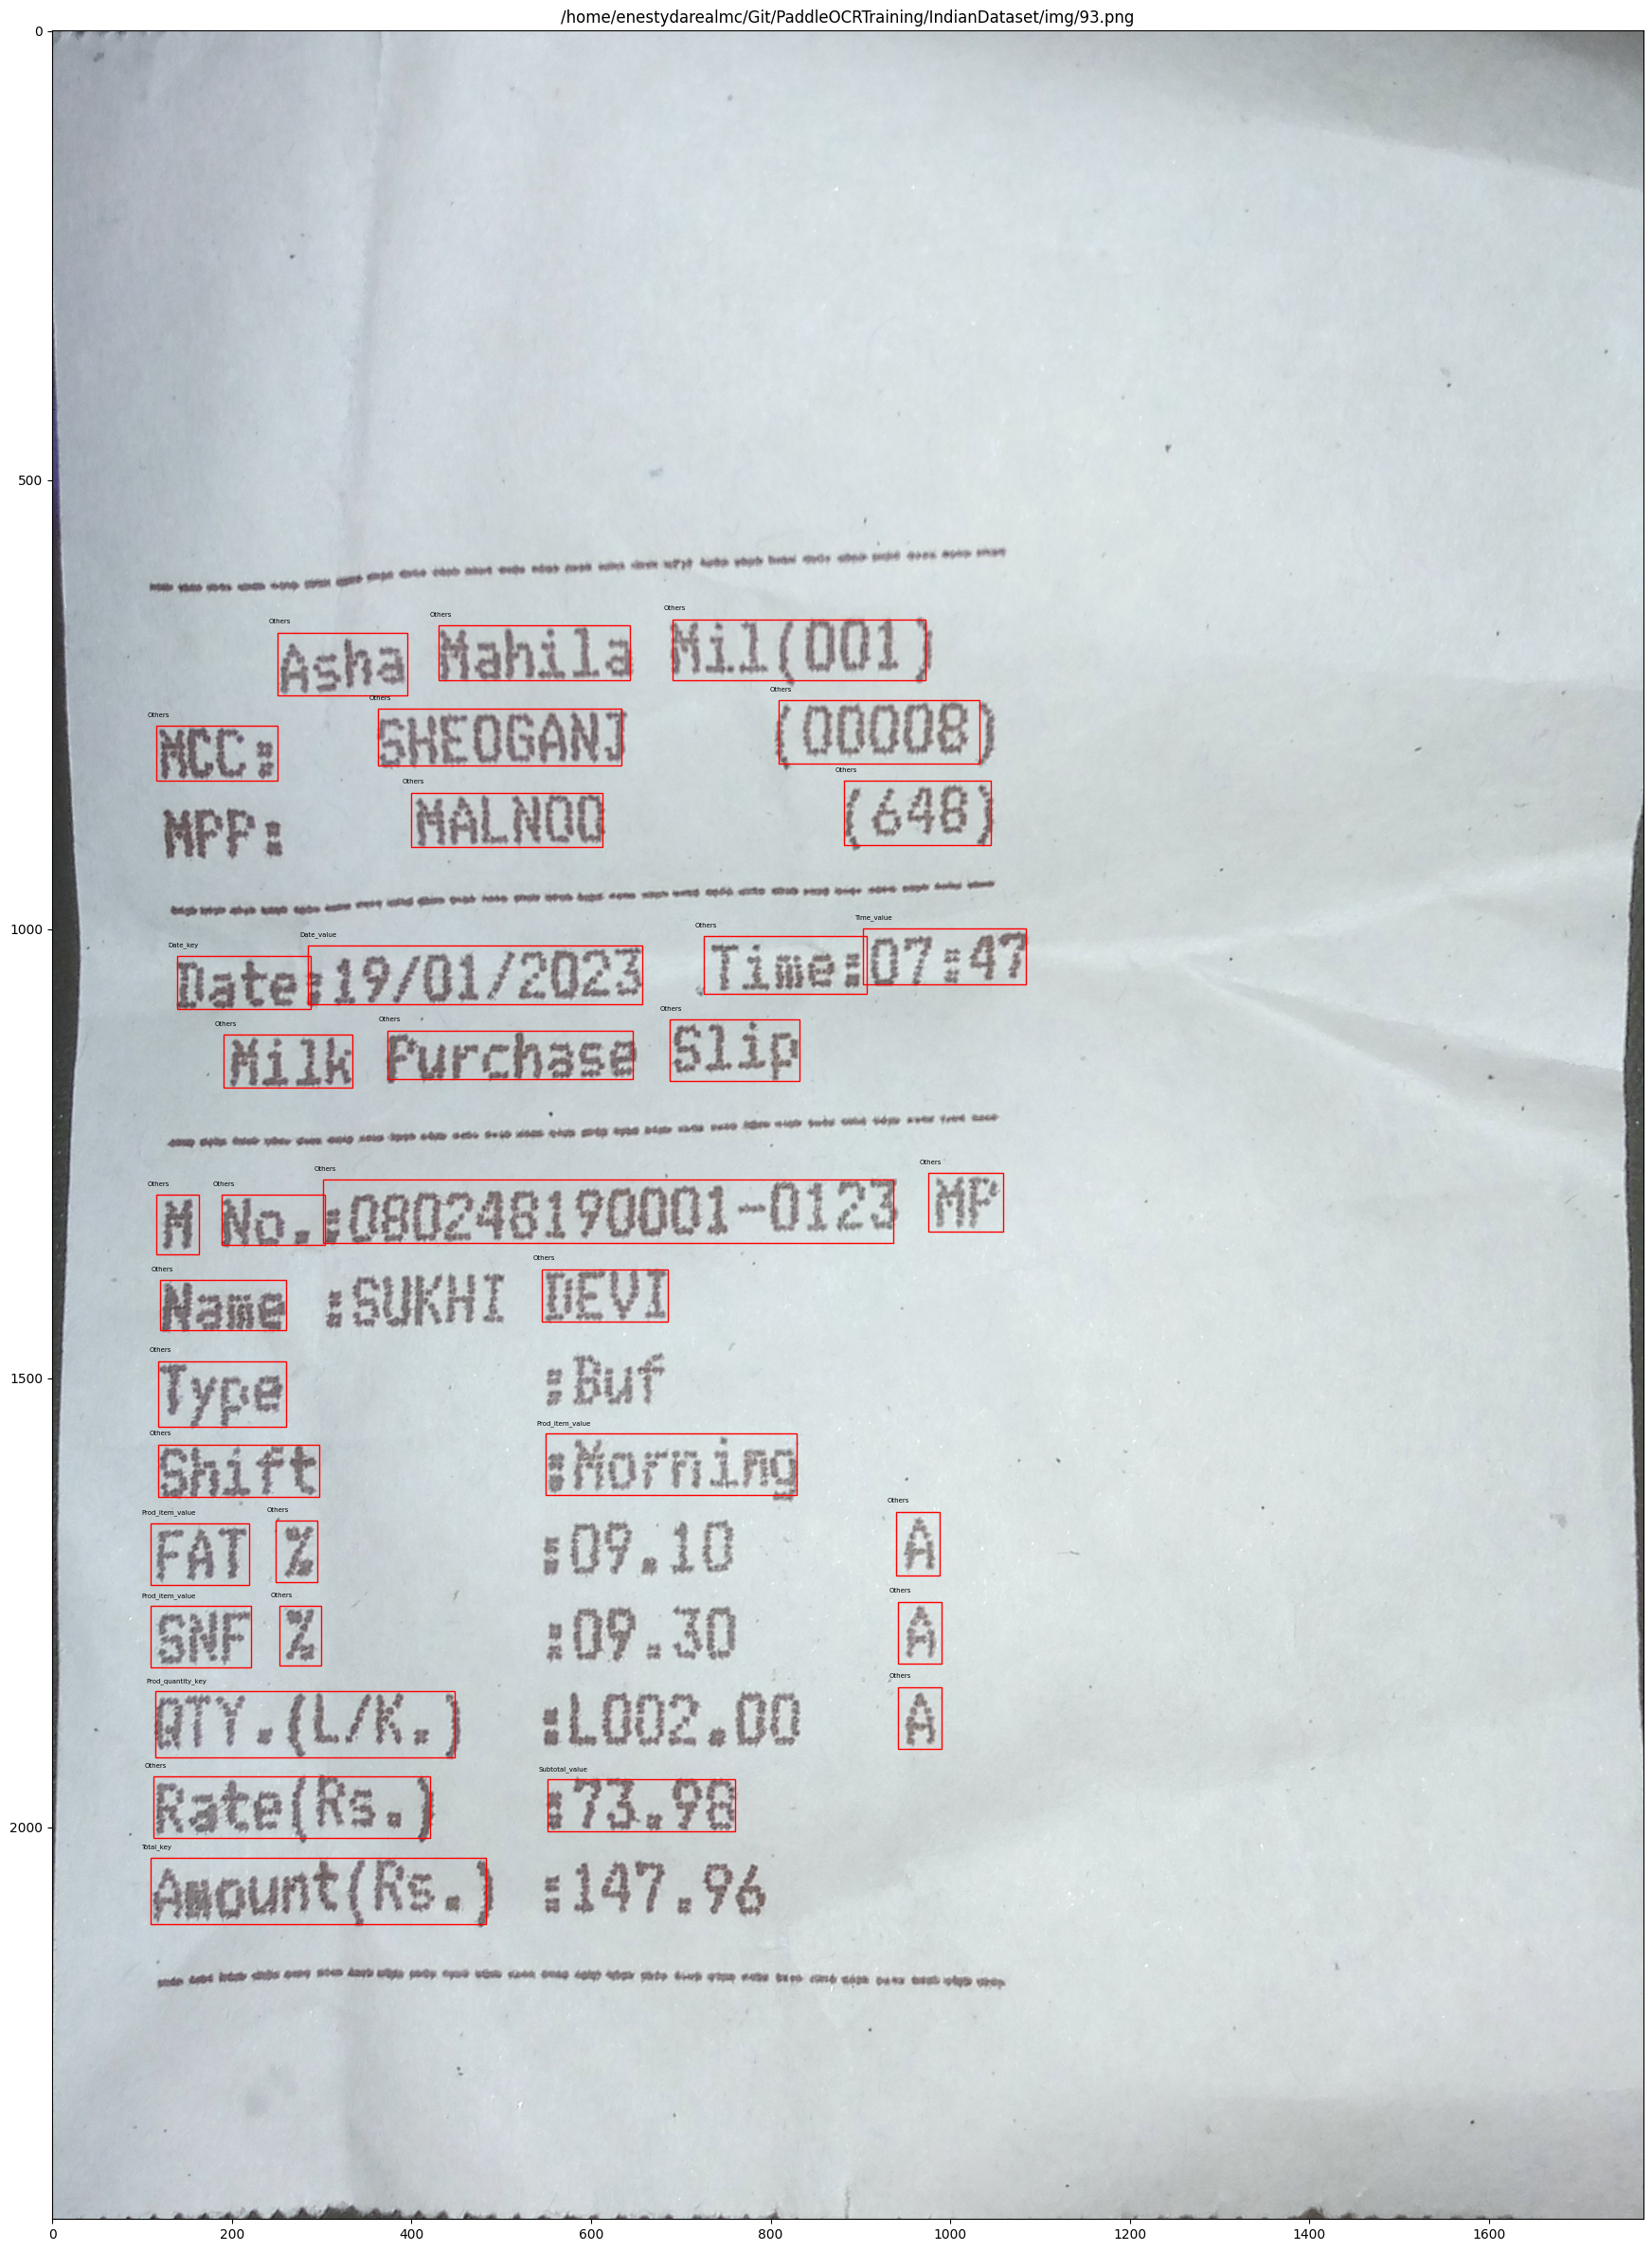

In [11]:
inference(r'/home/enestydarealmc/Git/PaddleOCRTraining/IndianDataset/img/93.png',inference_model, processor, ocr_model)